<a href="https://colab.research.google.com/github/washialiamos/washialiamos/blob/main/BTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [8]:
print(tf.__version__)

2.15.0


In [10]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset),'aclImdb')

84125825/84125825 [==============================] - 10s 0us/step


In [11]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [12]:
remove_dir = os.path.join(train_dir, 'unsup')

In [13]:
shutil.rmtree(remove_dir)

In [17]:
batch_size = 32
seed = 42
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'training',
    seed = seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [19]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Labe", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Labe 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into c

In [20]:
print("Label 0 means", raw_train_ds.class_names[0])
print("Label 1 means", raw_train_ds.class_names[1])

Label 0 means neg
Label 1 means pos


In [23]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'validation',
    seed = seed

    )

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [24]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size = batch_size
)

Found 25000 files belonging to 2 classes.


In [33]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [34]:
max_features = 1000
sequence_length = 250
vectorize_layer = layers.TextVectorization(
standardize = custom_standardization,
  max_tokens = max_features,
   output_mode = 'int',
    output_sequence_length = sequence_length
)

In [35]:
train_text = raw_train_ds.map(lambda x, y:x)
vectorize_layer.adapt(train_text)

In [30]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [43]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [44]:
AUTOTUNE =tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)



In [45]:
embedding_dim = 16

In [46]:
model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          16000     
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 16017 (62.57 KB)
Trainable params: 16017 (62.57 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [47]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [48]:
epochs=10
history=model.fit(
    train_ds, validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 8s 11ms/step - loss: 0.6690 - binary_accuracy: 0.6574 - val_loss: 0.6301 - val_binary_accuracy: 0.7324
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5798 - binary_accuracy: 0.7596 - val_loss: 0.5373 - val_binary_accuracy: 0.7844
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4974 - binary_accuracy: 0.8035 - val_loss: 0.4704 - val_binary_accuracy: 0.8118
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4436 - binary_accuracy: 0.8255 - val_loss: 0.4299 - val_binary_accuracy: 0.8204
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4098 - binary_accuracy: 0.8339 - val_loss: 0.4056 - val_binary_accuracy: 0.8320
Epoch 6/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3897 - binary_accuracy: 0.8380 - val_loss: 0.3901 - val_binary_accuracy: 0.8386
Epoch 7/10
625/625 [==============================] - 4s 7ms/s

In [49]:
loss, accuracy = model.evaluate(test_ds)
print("Loss:", loss*100)
print("Accuracy:", accuracy*100)

782/782 [==============================] - 4s 5ms/step - loss: 0.3598 - binary_accuracy: 0.8459
Loss: 35.975927114486694
Accuracy: 84.59200263023376


In [50]:
history_dict=history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

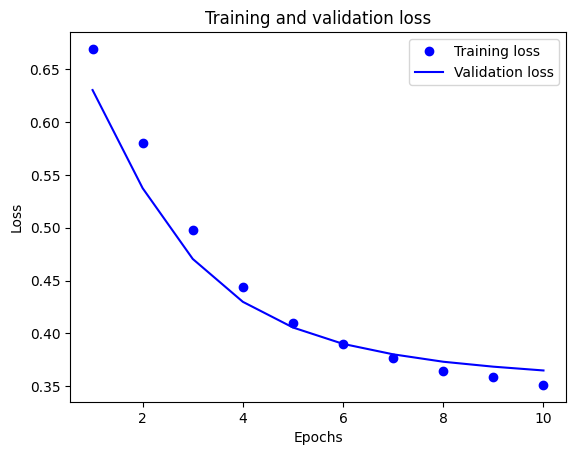

In [51]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

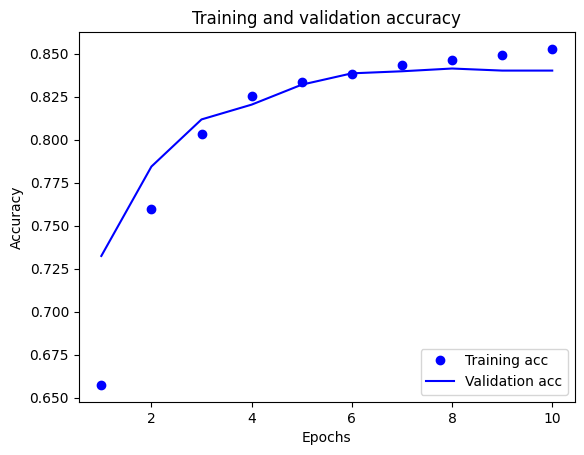

In [52]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [53]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 6s 7ms/step - loss: 0.3598 - accuracy: 0.8459
0.8459200263023376


In [54]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 407ms/step


array([[0.6290495 ],
       [0.45245597],
       [0.368776  ]], dtype=float32)

In [55]:
# Preprocess the examples using the vectorize_layer
import numpy as np

# Preprocess the examples using the vectorize_layer
numerical_examples = vectorize_layer(examples)

# Predict sentiment labels for the numerical examples
predictions = model.predict(numerical_examples)

# Convert probabilities to binary labels (0 for negative, 1 for positive)
binary_predictions = np.where(predictions >= 0.5, 1, 0)

# Print the predictions
for example, prediction in zip(examples, binary_predictions):
    sentiment = "positive" if prediction == 1 else "negative"
    print(f"Sentence: '{example}' -> Predicted sentiment: {sentiment} ({prediction})")

numerical_examples = vectorize_layer(examples)

# Predict sentiment labels for the numerical examples
predictions = model.predict(numerical_examples)

# Convert probabilities to binary labels (0 for negative, 1 for positive)
binary_predictions = np.where(predictions >= 0.5, 1, 0)

# Print the predictions
for example, prediction in zip(examples, binary_predictions):
    sentiment = "positive" if prediction == 1 else "negative"
    print(f"Sentence: '{example}' -> Predicted sentiment: {sentiment} ({prediction})")

1/1 [==============================] - 0s 56ms/step
Sentence: 'The movie was great!' -> Predicted sentiment: positive ([1])
Sentence: 'The movie was okay.' -> Predicted sentiment: negative ([0])
Sentence: 'The movie was terrible...' -> Predicted sentiment: negative ([0])
1/1 [==============================] - 0s 22ms/step
Sentence: 'The movie was great!' -> Predicted sentiment: positive ([1])
Sentence: 'The movie was okay.' -> Predicted sentiment: negative ([0])
Sentence: 'The movie was terrible...' -> Predicted sentiment: negative ([0])
